In [7]:
import matplotlib.pyplot as plt

from ALLCools.clustering import tsne
from ALLCools.plot import *
from ALLCools.integration import SeuratIntegration
from wmb import brain, cemba,aibs

import scanpy as sc
import anndata
from harmonypy import run_harmony
import pandas as pd
import numpy as np
import pathlib

In [11]:
#parameters
group_name = "Slice3-4_Neu"

In [12]:
_slice, cell_class = group_name.split('_')

In [2]:
adata = anndata.read_h5ad('final_with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 60198 × 448
    obs: 'blank_count', 'n_counts', 'n_genes', 'Modality', 'L4Region', 'CellType', 'DissectionRegion', 'leiden'
    var: 'chrom-mC', 'cov_mean-mC', 'end-mC', 'start-mC', 'cef-mC', 'id-merfish'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca_integrate', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
mc_data = adata[adata.obs['Modality'] == 'mC']
merfish_data = adata[adata.obs['Modality'] == 'merfish']

In [4]:
celltype_palette =cemba.get_cell_type_palette()
region_palette = brain.get_dissection_region_palette('CEMBA')

In [8]:
p = pathlib.Path("figure/")
p.mkdir(parents=True, exist_ok=True)

## plot meta

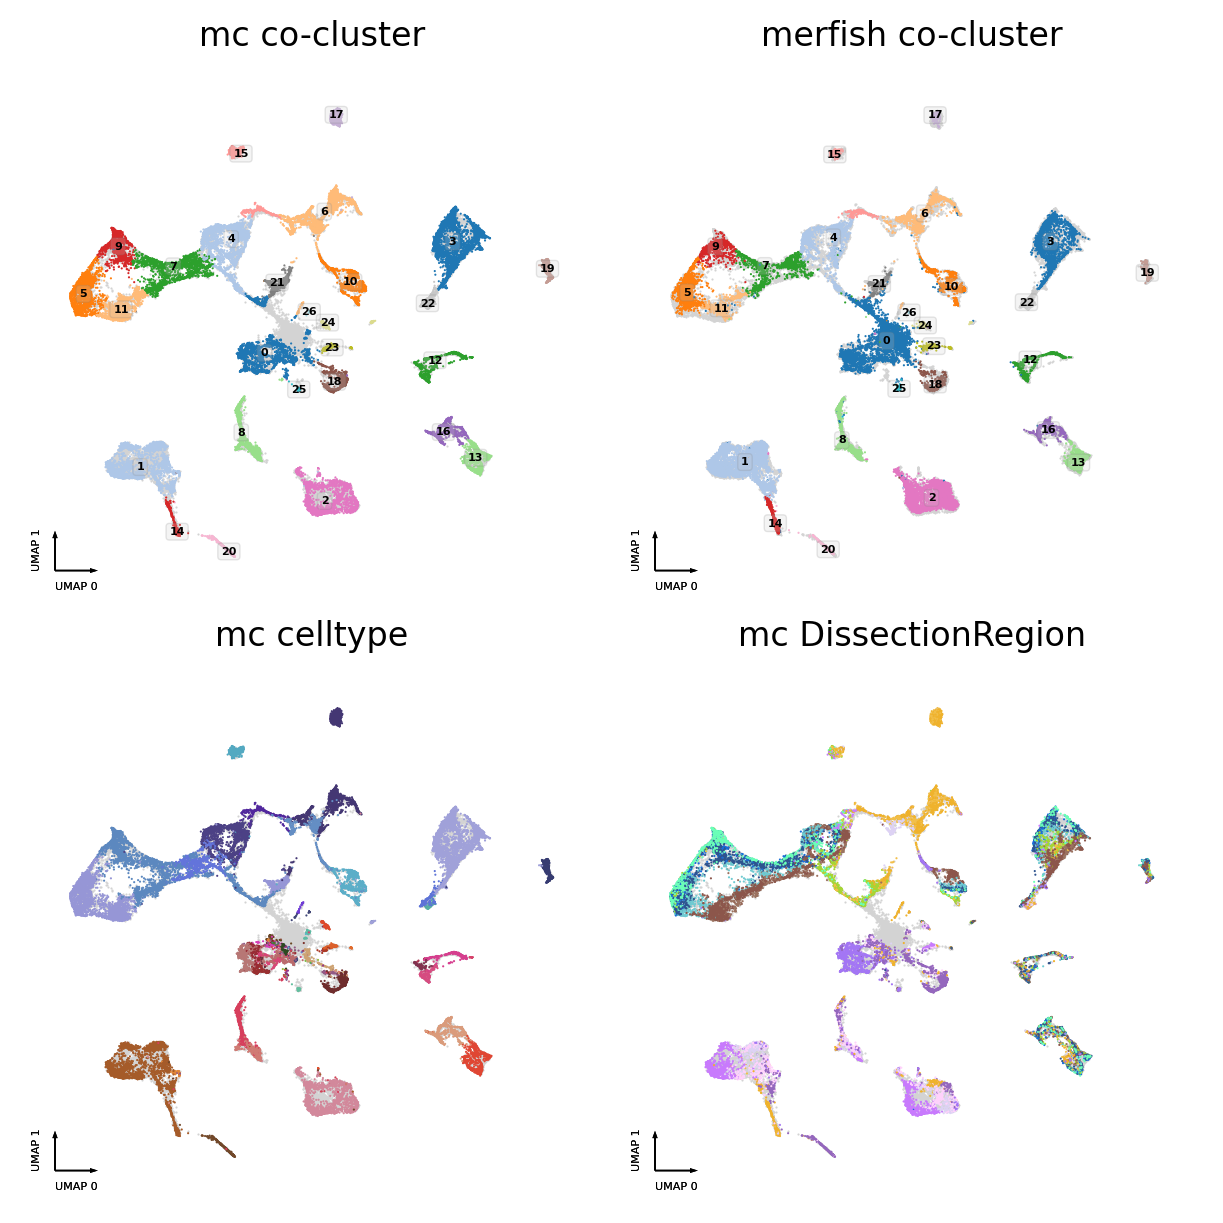

In [43]:
coord_base = 'umap'
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(6, 6),
                         dpi=200,
                         constrained_layout=True)

ax = axes[0,0]
categorical_scatter(data=merfish_data,
                    coord_base=coord_base,
                    max_points=None,
                    hue=None,
                    scatter_kws=dict(color='lightgrey'),
                    ax=ax)
categorical_scatter(
    data=mc_data,
    ax=ax,
    coord_base=coord_base,
    hue='leiden',
    text_anno='leiden',
    palette='tab20',
    max_points=None,
)
ax.set_title('mc co-cluster')

ax = axes[0,1]
categorical_scatter(data=mc_data,
                    coord_base=coord_base,
                    max_points=None,
                    hue=None,
                    scatter_kws=dict(color='lightgrey'),
                    ax=ax)
categorical_scatter(
    data=merfish_data,
    ax=ax,
    coord_base=coord_base,
    hue='leiden',
    text_anno='leiden',
    palette='tab20',
    max_points=None,
)
ax.set_title('merfish co-cluster')

ax = axes[1,0]
categorical_scatter(data=merfish_data,
                    coord_base=coord_base,
                    max_points=None,
                    hue=None,
                    scatter_kws=dict(color='lightgrey'),
                    ax=ax)

celltype_palette =cemba.get_cell_type_palette()
categorical_scatter(
    data=mc_data,
    ax=ax,
    coord_base=coord_base,
    hue='CellType',
    #text_anno='CellType',
    palette=celltype_palette,
)
ax.set_title('mc celltype')

ax = axes[1,1]
categorical_scatter(data=merfish_data,
                    coord_base=coord_base,
                    max_points=None,
                    hue=None,
                    scatter_kws=dict(color='lightgrey'),
                    ax=ax)

region_palette = brain.get_dissection_region_palette('CEMBA')
categorical_scatter(
    data=mc_data,
    ax=ax,
    coord_base=coord_base,
    hue='DissectionRegion',
    #text_anno='DissectionRegion',
    palette=region_palette,
)
ax.set_title('mc DissectionRegion')
fig.savefig('figure/mc_meta_umap_coords.pdf', bbox_inches='tight')

# Check merfish

In [19]:
cell_meta = pd.read_hdf("/cemba/MERFISH/MERFISH.TotalWatershedMetadata.Rotation.BasicFilter.hdf")

In [28]:
slice_info = {'Slice1-2':[[1,2],'C1'],
          'Slice3-4':[[3,4],'C3'],
          'Slice5-6':[[5,6],'C5'],
          'Slice7-8':[[7,8],'C7'],
          'Slice9-10':[[9,10],'C9'],
          'Slice11-12':[[11,12],'C11']}

reps = ["R1","R2"]
loc = slice_info[_slice][1]

samples = []
for rep in reps:
    sample = f"{loc}-{rep}"
    samples.append(sample)

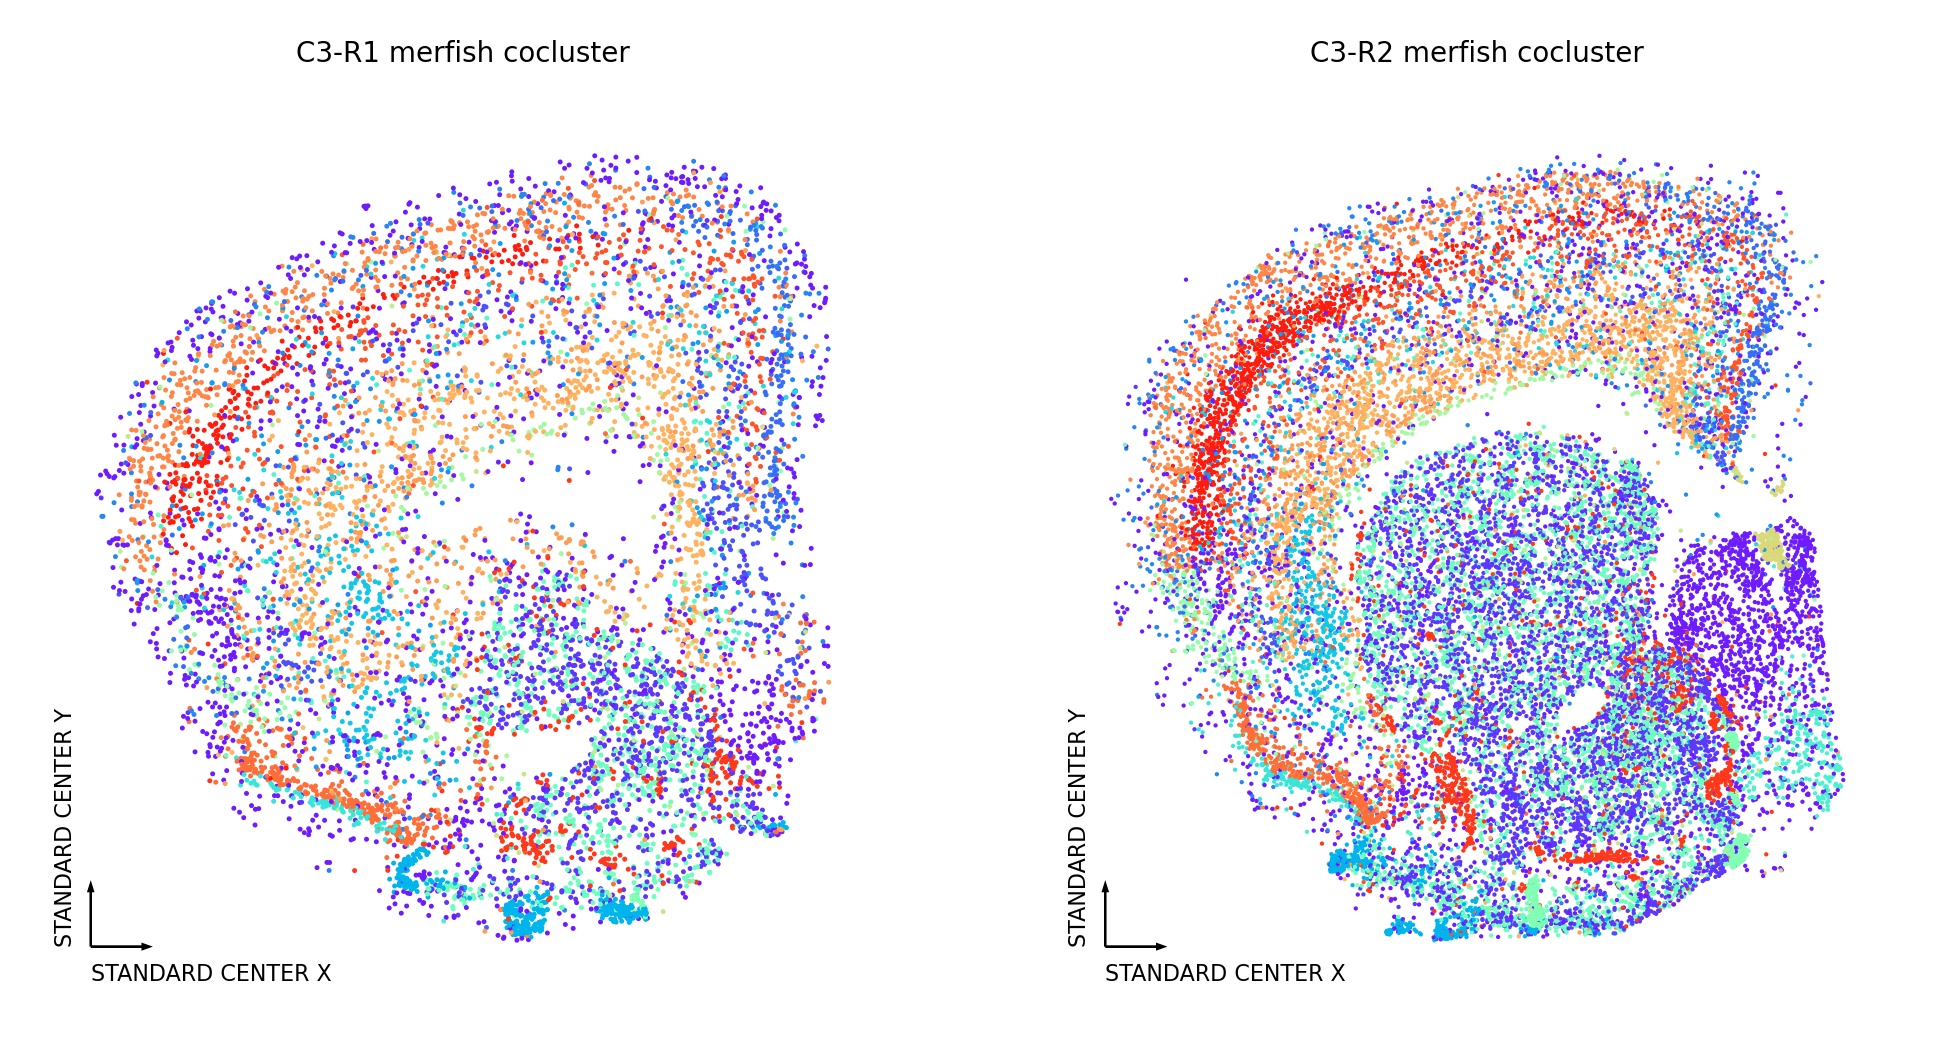

In [31]:
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=2, dpi=400)
    
for sample, ax in zip(samples, axes.ravel()):
    plot_data = cell_meta.query(f'sample == "{sample}"')
    plot_data['leiden'] = merfish_data.obs['leiden']
    
    categorical_scatter(data=plot_data,
                        x="standard_center_x",
                        y="standard_center_y",
                        max_points=None,
                        hue='leiden',
                        ax=ax)
    
    ax.set_title(f'{sample} merfish cocluster', fontsize = 5)
fig.savefig('figure/merfish_cell_leiden.pdf', bbox_inches='tight')   

# Check mC

In [33]:
path = 'mC_MERFISHxNN.npz'

In [34]:
# G shows the nearest 25 merfish cells to each mC cell
# D is the distance

G = np.load(path)['G']
D = np.load(path)['D']

mc_cell = np.load(path, allow_pickle=True)['mc_cell']
merfish_cell = np.load(path, allow_pickle=True)['merfish_cell']

In [36]:
# select the top 10 near merfish cells to each mC cell
new_G = G[:,:10]

num_columns = new_G.shape[1]
num_rows = new_G.shape[0]

ids = np.random.randint(0, num_columns, size=num_rows)
mc_to_merfish_cell = new_G[np.arange(num_rows), ids]
mc_to_merfish_cell = [merfish_cell[index]for index in mc_to_merfish_cell]

In [37]:
print(f'in totoal of {len(set(mc_to_merfish_cell))} merfish cells used')

in totoal of 9438 merfish cells used


In [38]:
mc_cells_info = pd.DataFrame(mc_to_merfish_cell, index = mc_cell, columns = ['merfish_cell'])

cell_meta = pd.read_hdf("/cemba/MERFISH/MERFISH.TotalWatershedMetadata.Rotation.BasicFilter.hdf")
mc_cells_info['standard_center_x'] = mc_cells_info['merfish_cell'].map(cell_meta['standard_center_x'].to_dict())
mc_cells_info['standard_center_y'] = mc_cells_info['merfish_cell'].map(cell_meta['standard_center_y'].to_dict())
mc_cells_info['sample'] = mc_cells_info['merfish_cell'].map(cell_meta['sample'].to_dict())

mc_cells_info['CellType'] = adata.obs['CellType']
mc_cells_info['DissectionRegion'] = adata.obs['DissectionRegion']
mc_cells_info['Class'] = [celltype.split(' ')[-1] for celltype in mc_cells_info['CellType'].tolist()] 

In [41]:
sample_var_list = [f'{sample}_{var}' for sample in samples for var in ['CellType','DissectionRegion']]
sample_var_list

['C3-R1_CellType',
 'C3-R1_DissectionRegion',
 'C3-R2_CellType',
 'C3-R2_DissectionRegion']

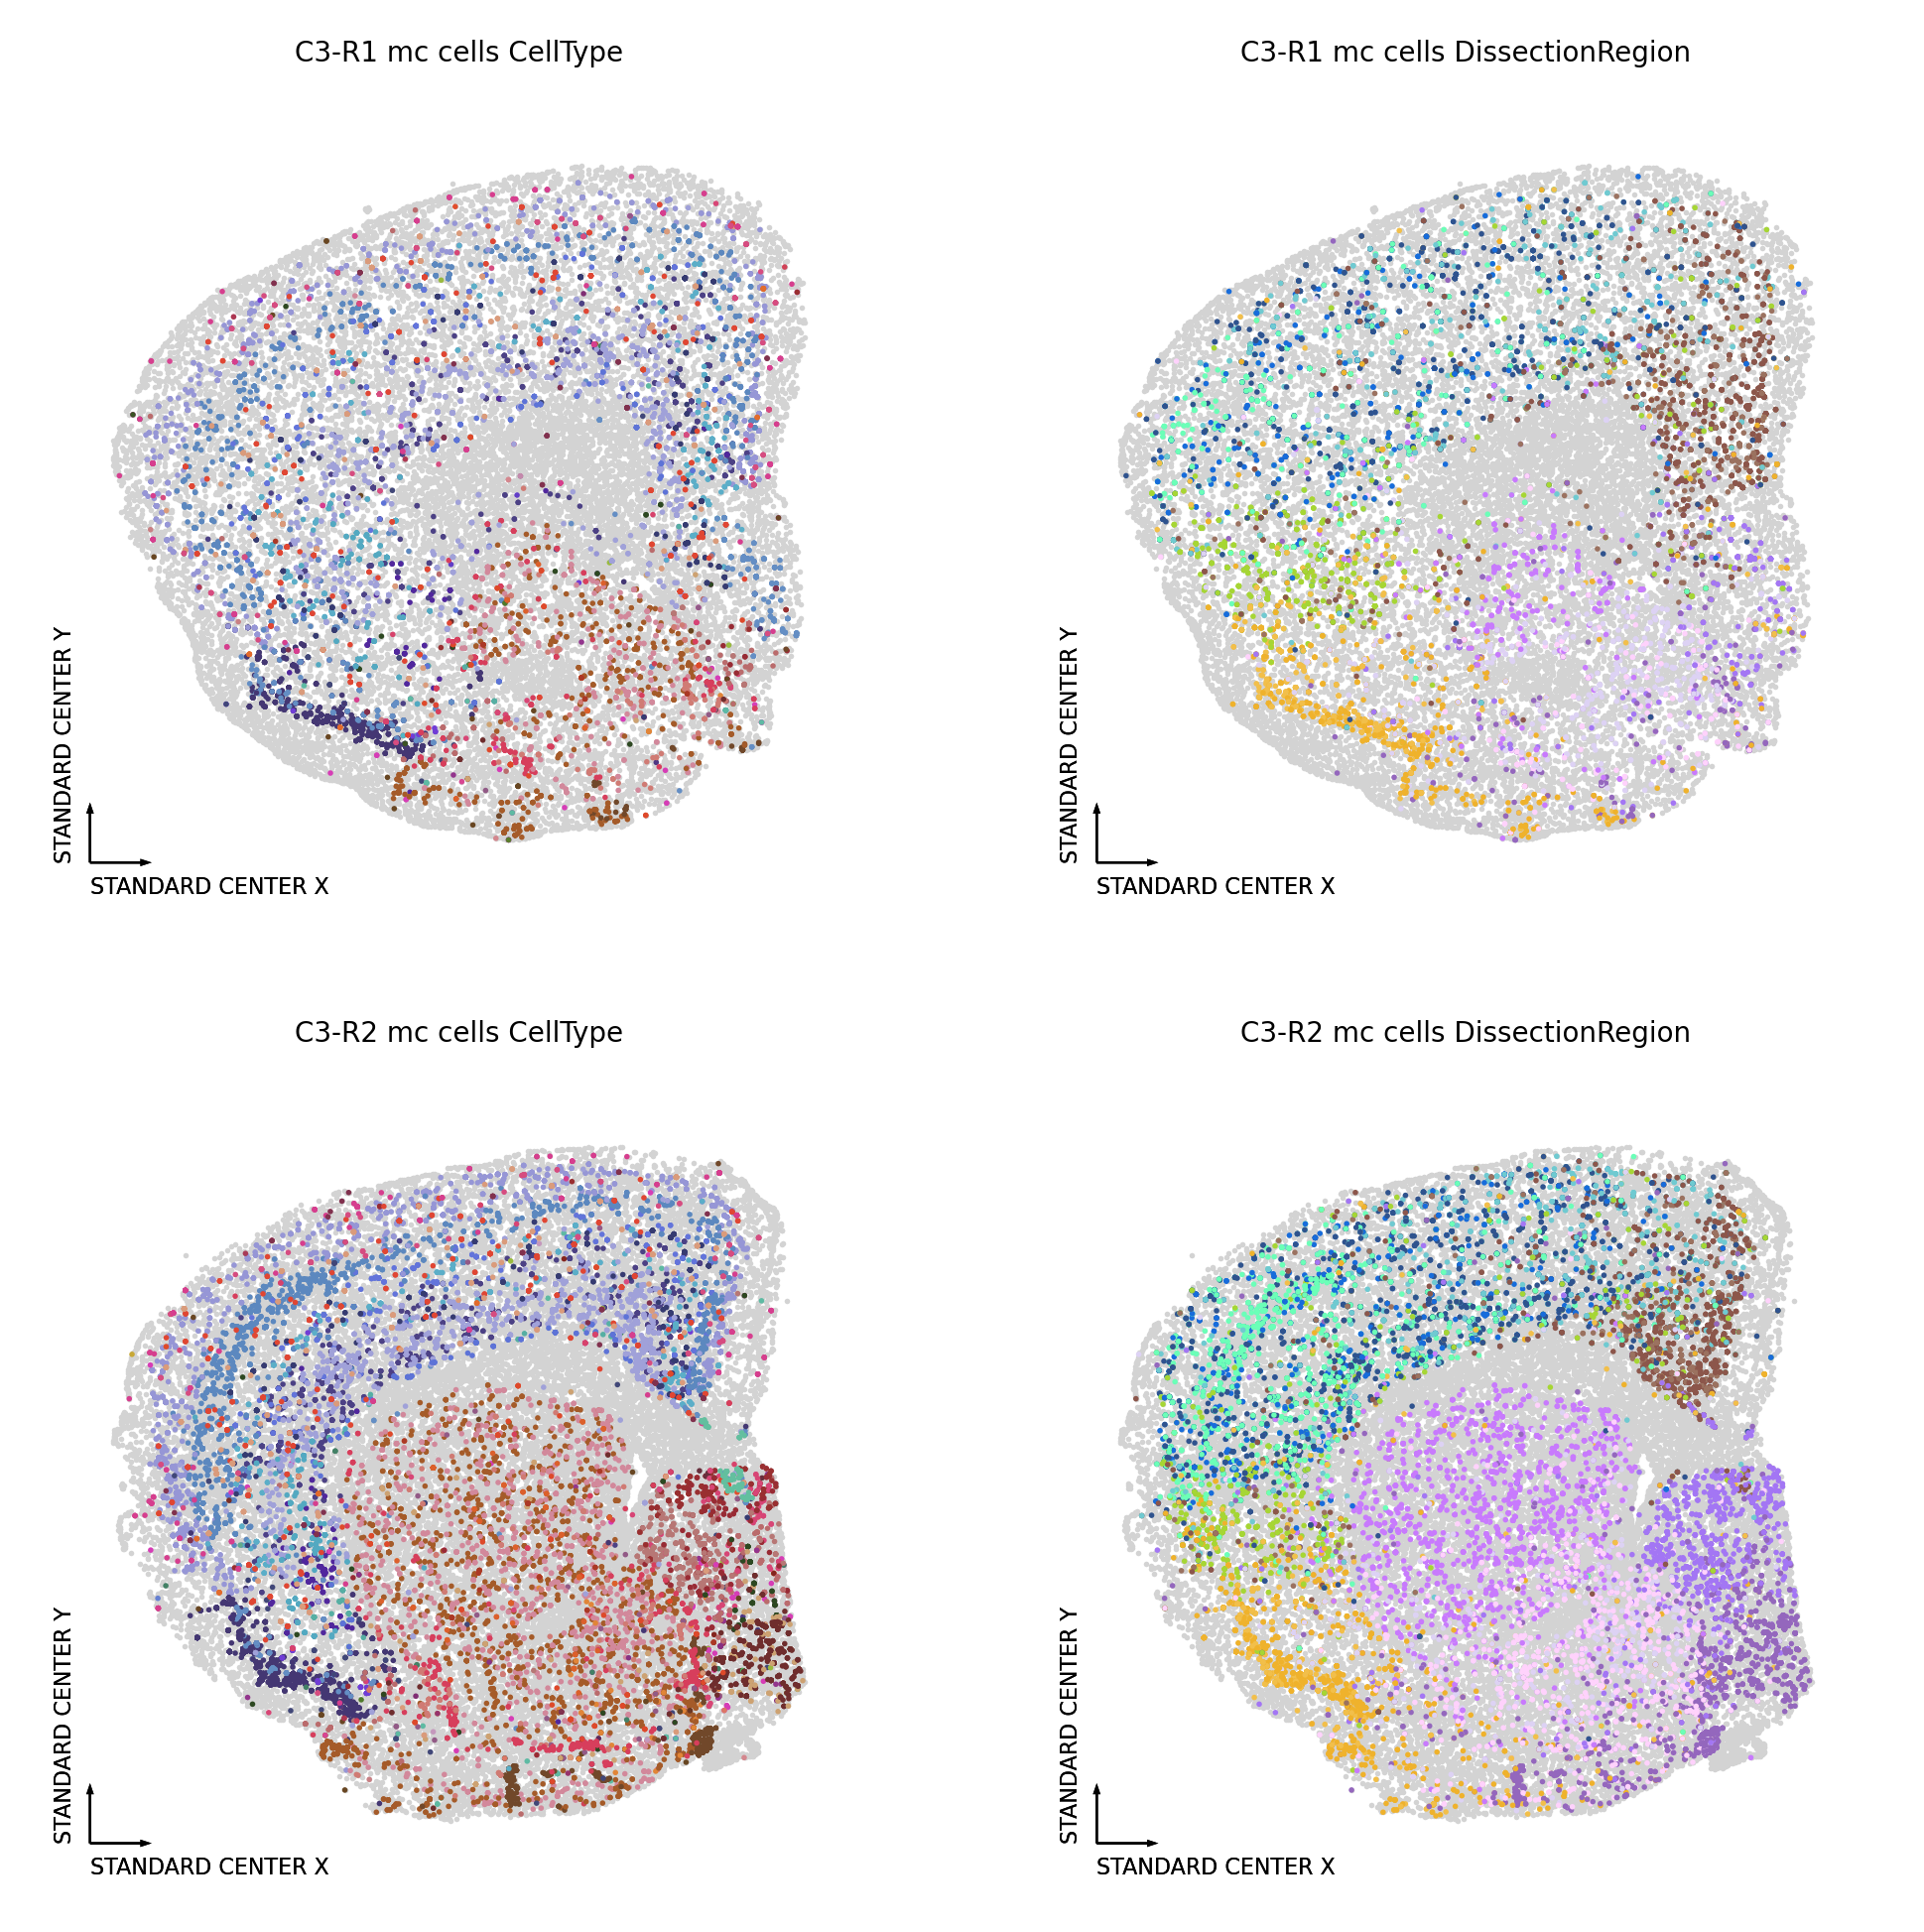

In [44]:
fig, axes = plt.subplots(figsize=(6, 6), nrows=2, ncols=2, dpi=400)
    
for sample_var, ax in zip(sample_var_list, axes.ravel()):
    sample, var = sample_var.split('_') 
    plot_data = mc_cells_info.query(f'sample == "{sample}"')
    merfish_plot_data = cell_meta.query(f'sample == "{sample}"')
    
    if var == 'CellType':
        palette = celltype_palette
    else:
        palette = region_palette
        
    categorical_scatter(data=merfish_plot_data,
                    x="standard_center_x",
                    y="standard_center_y",
                    max_points=None,
                    scatter_kws=dict(color='lightgrey'),
                    s = 1,
                    ax=ax)
        
    categorical_scatter(data=plot_data,
                        x="standard_center_x",
                        y="standard_center_y",
                        max_points=None,
                        palette = palette,
                        hue = var,
                        s = 1,
                        ax=ax)
    ax.set_title(f'{sample} mc cells {var}', fontsize = 5)  
fig.savefig('figure/mc_meta_merfish_coords.pdf', bbox_inches='tight')   

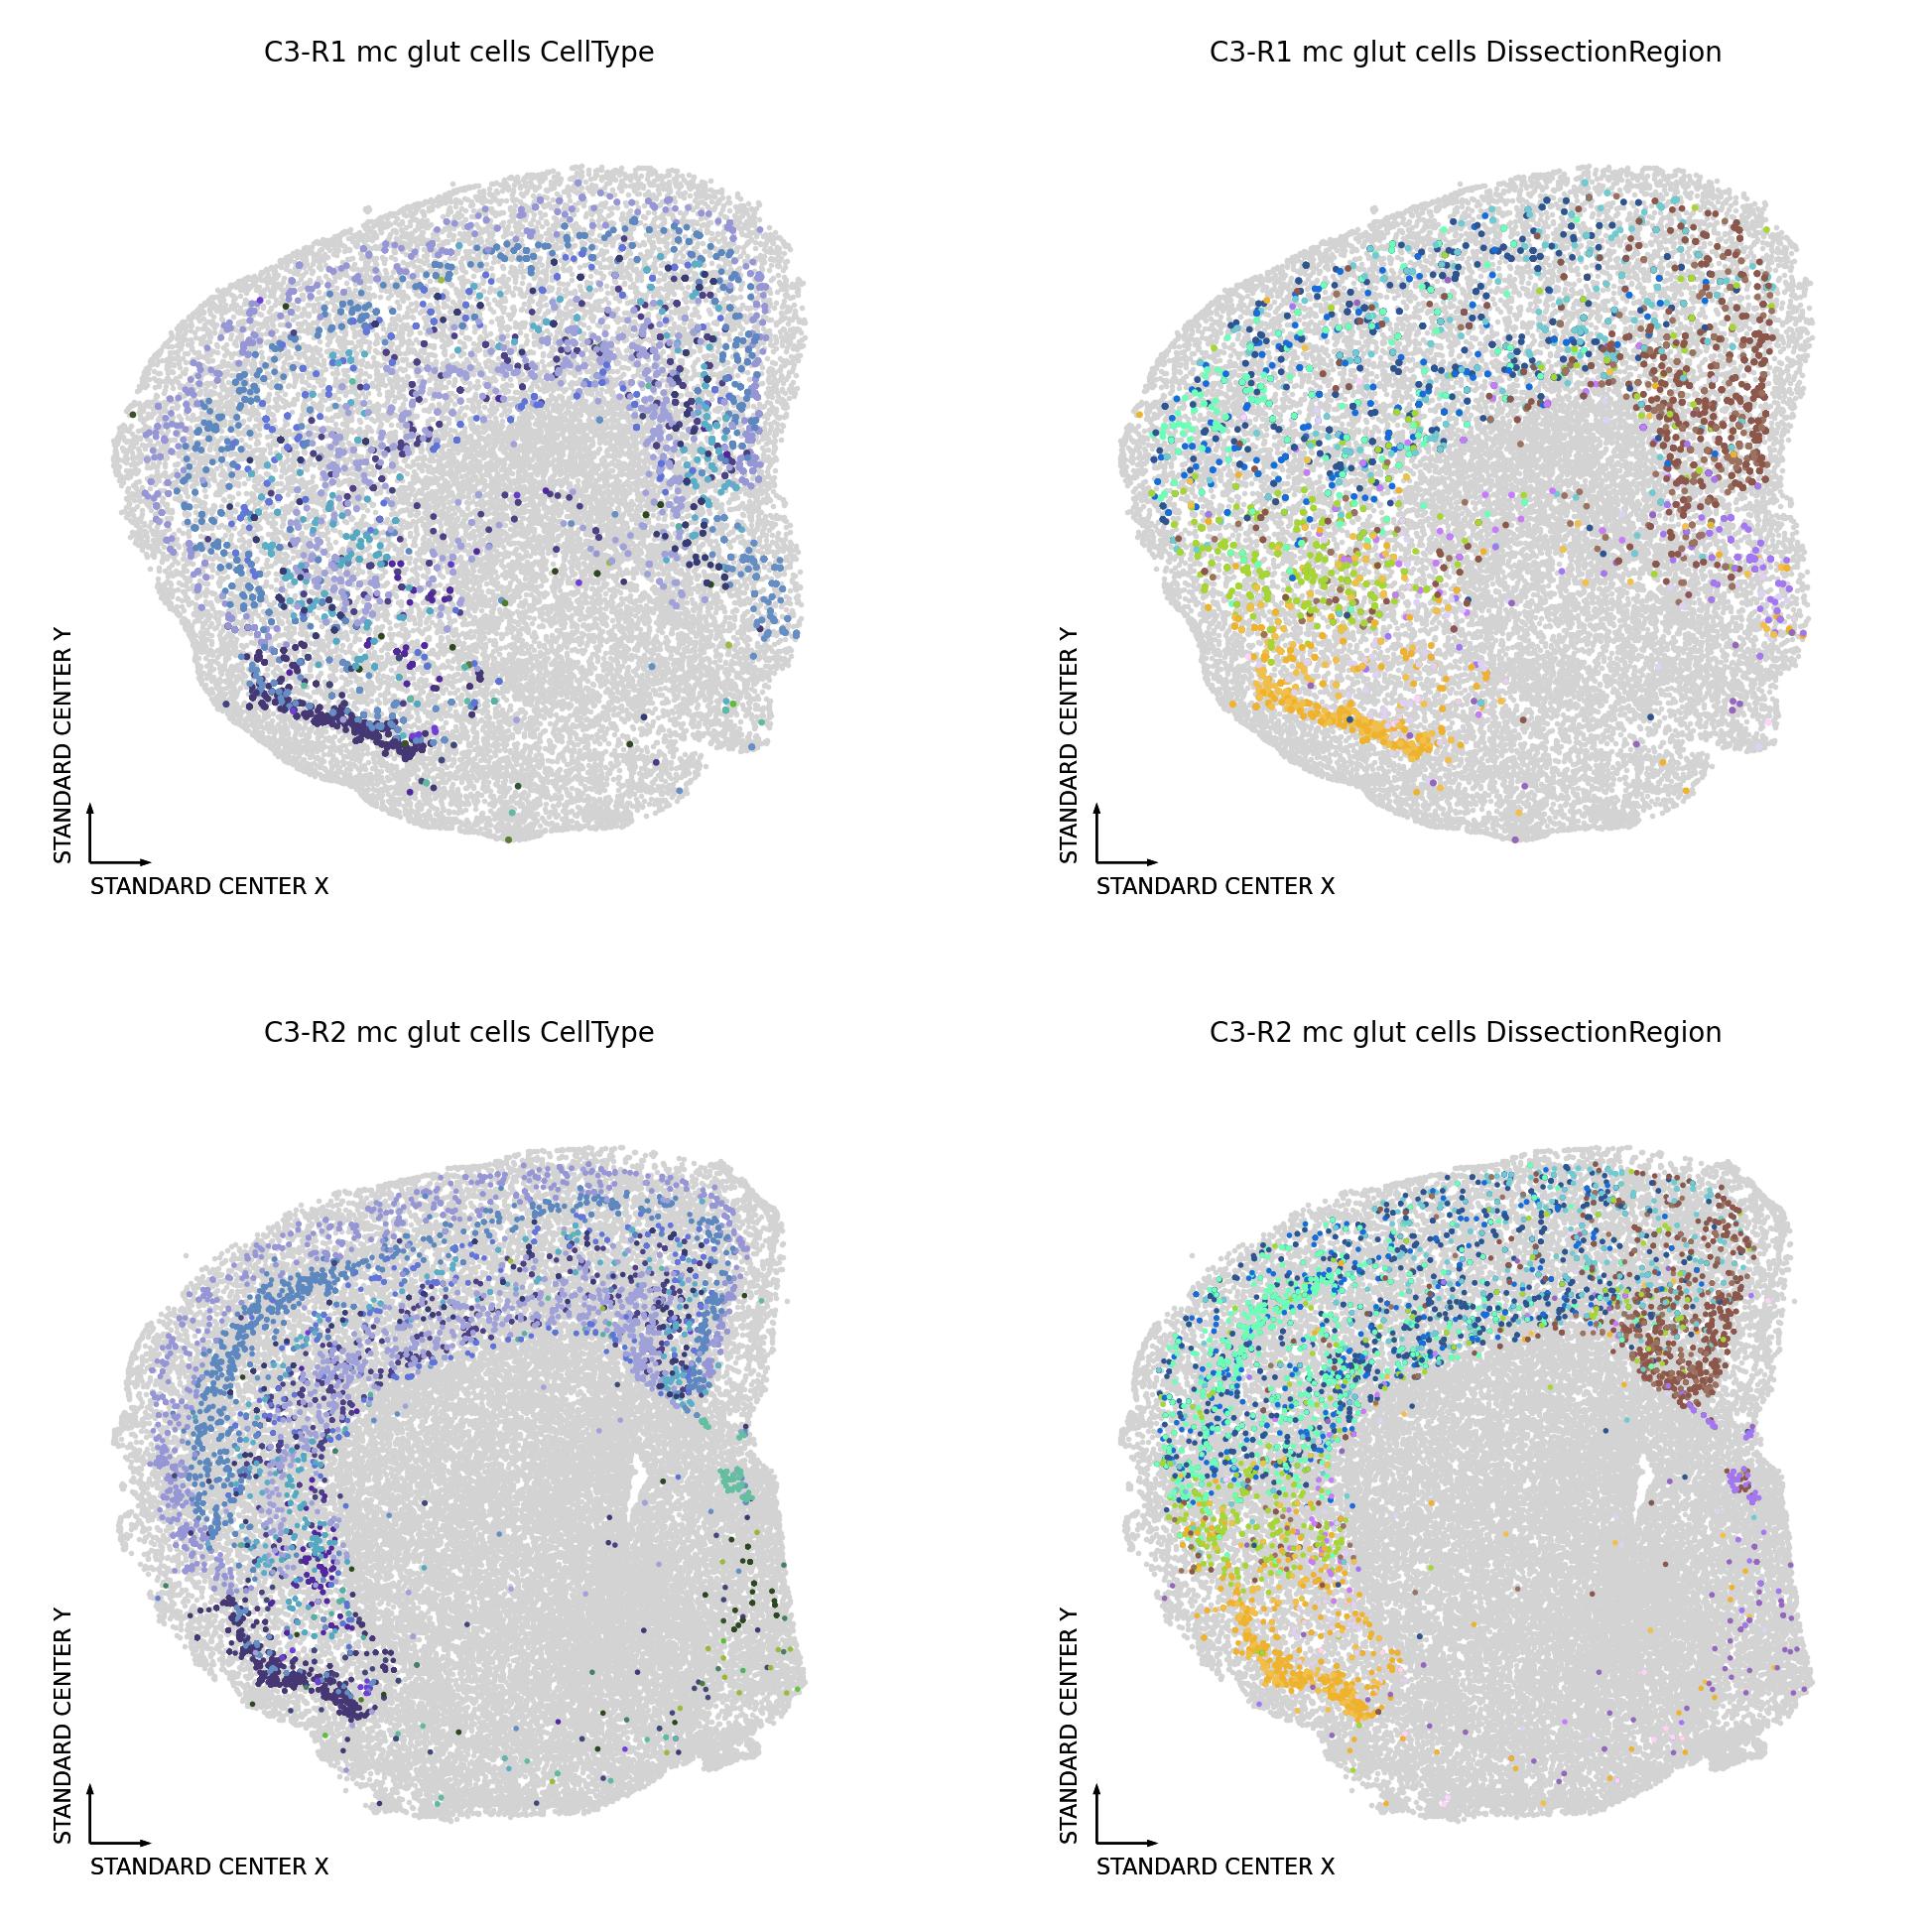

In [45]:
glut_mc_cells_info = mc_cells_info[mc_cells_info['Class'] == 'Glut']

fig, axes = plt.subplots(figsize=(6, 6), nrows=2, ncols=2, dpi=400)
    
for sample_var, ax in zip(sample_var_list, axes.ravel()):
    sample, var = sample_var.split('_') 
    plot_data = glut_mc_cells_info.query(f'sample == "{sample}"')
    merfish_plot_data = cell_meta.query(f'sample == "{sample}"')
    
    if var == 'CellType':
        palette = celltype_palette
    else:
        palette = region_palette
    
    categorical_scatter(data=merfish_plot_data,
                    x="standard_center_x",
                    y="standard_center_y",
                    max_points=None,
                    scatter_kws=dict(color='lightgrey'),
                    s = 1,
                    ax=ax)
    
    categorical_scatter(data=plot_data,
                        x="standard_center_x",
                        y="standard_center_y",
                        max_points=None,
                        palette = palette,
                        hue = var,
                        ax=ax)
    ax.set_title(f'{sample} mc glut cells {var}', fontsize = 5)  
fig.savefig('figure/glut_mc_meta_merfish_coords.pdf', bbox_inches='tight')      